## GECCO2019 - Bi-objective Traveling Thief Competition

This worksheet clones the GECCO 2019 travelling thief repository, which includes the node coordinates, item locations and other important params such as the thiefs speed and knapsack capacity, for each of the 9 test sets as defined in the paper "A Comprehensive Benchmark Set and Heuristics for the Traveling Thief Problem, Polyakovskiy et al" and supplies them as python objects ready for your individual algorithms to use.

If creating a network graph from the node coordinates the problem assumes a fully connected network (i.e. it is permissible for the thief to travel from any node, to any other node, should it wish to do so, the distance being the *integer ceiling* of the euclidean distance between the two nodes)

There is also a non-dominated solution tracker, which accepts an arbitrary number of solutions, picks the maximum number of pareto-optimal non-dominated solutions permitted for the problem, and outputs them as a files in the competition submission format

In [ ]:
from collections import namedtuple
import itertools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import math
import numpy as np
import os
import random
import multiprocessing

# Problem Definition

In [ ]:
# get the data
!git clone https://github.com/julesy89/gecco19-thief

fatal: destination path 'gecco19-thief' already exists and is not an empty directory.


In [ ]:
# list the defined problems
loaddir = './gecco19-thief/src/main/resources/'
#!cp /content/drive/MyDrive/Colab\ Notebooks/BankProblem.txt $loaddir 
!ls $loaddir

a280-n1395.txt	fnl4461-n22300.txt  pla33810-n169045.txt  test-example-n4.txt
a280-n2790.txt	fnl4461-n44600.txt  pla33810-n338090.txt
a280-n279.txt	fnl4461-n4460.txt   pla33810-n33809.txt


In [ ]:
# define the structure of the problem params
TTPNode = namedtuple('TTPNode', 'index x y')
TTPItem = namedtuple('TTPItem', 'index profit weight node')
class TTPProblem:
    def __init__(self):
        self.name = ''
        self.dimension = 0
        self.num_items = 0
        self.knapsack_capacity = 0
        self.min_speed = 0
        self.max_speed = 0
        self.nodes = {}
        self.items = {}
        self.items_at = {}
        self.items_list = []
        self.items_total_weight = 0
        self.dist_memo = None

    def __repr__(self):
        return self.name + "(d=" + str(self.dimension) + ",n=" + str(self.num_items) + ")"
    
    def index_items_at(self):
        self.items_at = {n.index:set() for n in self.nodes.values()}
        self.items_total_weight = 0
        for i in self.items.values():
            self.items_at[i.node].add(i.index)
            self.items_list.append(i)
            self.items_total_weight += i.weight
        self.packing_ratio = self.knapsack_capacity / self.items_total_weight
        if self.dimension <= 1000:
            self.dist_memo = -np.ones([self.dimension, self.dimension]) # O(n^2) so <= 1M is reasonable
    
    def dist_between(self, i, j):
        # idea by Siming to cache distance lookups for small problems
        if self.dist_memo is not None:
            dist = self.dist_memo[i-1][j-1]
            if dist == -1:
                dist = self.calc_dist_between(i, j)
                self.dist_memo[i-1][j-1] = dist
            return dist
        else:
            return self.calc_dist_between(i, j)

    def thief_speed(self, w):
        '''Speed of the thief laden with weight w'''
        return self.max_speed - (w / self.knapsack_capacity) * (self.max_speed - self.min_speed)

    def calc_dist_between(self, i, j):
        dx = self.nodes[i].x - self.nodes[j].x
        dy = self.nodes[i].y - self.nodes[j].y
        return math.ceil(math.sqrt(dx**2 + dy**2))
      
    def weigh_knapsack(self, k):
        return sum(self.items[i].weight for i in k)

    def from_packing_plan(self, packing):
        return {v.index for p, v in zip(packing, self.items_list) if p}

In [ ]:
# load each into a problem map
problems = {}
for f in os.listdir(loaddir):
    with open(loaddir + f) as fh:
        print(f"loading {fh.name}")
        problem = TTPProblem()
        problem.filename = f.split('.')[0]
        problem.name = fh.readline().split(':')[1].lstrip(' \t').rstrip('\r\n')
        fh.readline() # knapsack data type ignored
        problem.dimension = int(fh.readline().split(':')[1].lstrip(' \t').rstrip('\r\n'))
        problem.num_items = int(fh.readline().split(':')[1].lstrip(' \t').rstrip('\r\n'))
        problem.knapsack_capacity = int(fh.readline().split(':')[1].lstrip(' \t').rstrip('\r\n'))
        problem.min_speed = float(fh.readline().split(':')[1].lstrip(' \t').rstrip('\r\n'))
        problem.max_speed = float(fh.readline().split(':')[1].lstrip(' \t').rstrip('\r\n'))
        fh.readline() # renting ratio ignored
        fh.readline() # edge weight types assumed ceil_2d
        fh.readline() # node_coord_section
        while True:
            x = fh.readline()
            if x.startswith("ITEMS"):
                break
            node = TTPNode(int(x.split()[0].lstrip(' \t').rstrip('\r\n')),
                           float(x.split()[1].lstrip(' \t').rstrip('\r\n')),
                           float(x.split()[2].lstrip(' \t').rstrip('\r\n')))
            problem.nodes[node.index] = node
        while True:
            x = fh.readline()
            if not x:
                break
            item = TTPItem(int(x.split()[0].lstrip(' \t').rstrip('\r\n')),
                           float(x.split()[1].lstrip(' \t').rstrip('\r\n')),
                           float(x.split()[2].lstrip(' \t').rstrip('\r\n')),
                           int(x.split()[3].lstrip(' \t').rstrip('\r\n')))
            problem.items[item.index] = item
        problem.index_items_at()
        problems[f] = problem

loading ./gecco19-thief/src/main/resources/pla33810-n33809.txt
loading ./gecco19-thief/src/main/resources/test-example-n4.txt
loading ./gecco19-thief/src/main/resources/fnl4461-n44600.txt
loading ./gecco19-thief/src/main/resources/fnl4461-n22300.txt
loading ./gecco19-thief/src/main/resources/fnl4461-n4460.txt
loading ./gecco19-thief/src/main/resources/a280-n1395.txt
loading ./gecco19-thief/src/main/resources/pla33810-n169045.txt
loading ./gecco19-thief/src/main/resources/a280-n2790.txt
loading ./gecco19-thief/src/main/resources/a280-n279.txt
loading ./gecco19-thief/src/main/resources/pla33810-n338090.txt


In [ ]:
# what's that look like?
problems

{'a280-n1395.txt': a280-TTP(d=280,n=1395),
 'a280-n279.txt': a280-TTP(d=280,n=279),
 'a280-n2790.txt': a280-TTP(d=280,n=2790),
 'fnl4461-n22300.txt': fnl4461-TTP(d=4461,n=22300),
 'fnl4461-n4460.txt': fnl4461-TTP(d=4461,n=4460),
 'fnl4461-n44600.txt': fnl4461-TTP(d=4461,n=44600),
 'pla33810-n169045.txt': pla33810-TTP(d=33810,n=169045),
 'pla33810-n33809.txt': pla33810-TTP(d=33810,n=33809),
 'pla33810-n338090.txt': pla33810-TTP(d=33810,n=338090),
 'test-example-n4.txt': Test(d=4,n=3)}

# Solution Definition

In [ ]:
# a possible solution to a problem
class InvalidSolutionException(BaseException):
    pass
class TTPSolution:
    def __init__(self, problem, route, items):
        self.problem = problem
        self.nodes = route
        self.items = items
        self.memo = {}
        self.valid = True
        try:
            self.total_time()
        except InvalidSolutionException:
            self.valid = False
        
    def __repr__(self):
        if self.valid:
            return "ValidSolution(t=" + str(self.total_time()) + ",p=" + str(self.total_profit()) + ")"
        else:
            return("InvalidSolution")
        
    def total_dist(self):
        while True:
            try:
                return self.memo['total_dist']
            except KeyError:
                self.memo['total_dist'] = sum(problem.dist_between(self.nodes[n], self.nodes[(n+1) % len(self.nodes)])
                                                for n in range(len(self.nodes)))
    def total_profit(self):
        while True:
            try:
                return self.memo['total_profit']
            except KeyError:
                self.memo['total_profit'] = sum(problem.items[i].profit for i in self.items)
        
    def total_weight(self):
        while True:
            try:
                return self.memo['total_weight']
            except KeyError:
                self.memo['total_weight'] = sum(problem.items[i].weight for i in self.items)
    
    # walks the route one city at a time, updating the knapsack with all items collected
    # thus far, and the thiefs speed after each leg
    def total_time(self):
        while True:
            try:
                return self.memo['total_time']
            except KeyError:
                ts = np.zeros(len(self.nodes))
                k = set()
                t = 0
                for n in range(len(self.nodes)):
                    d = problem.dist_between(self.nodes[n], self.nodes[(n+1) % len(self.nodes)])
                    k |= self.items & problem.items_at[self.nodes[n]]
                    w = problem.weigh_knapsack(k)
                    if w > problem.knapsack_capacity:
                        raise InvalidSolutionException()
                    ts[n] = problem.thief_speed(w)
                    t += d / ts[n]
                self.memo['total_time'] = t
                self.memo['thief_speed'] = ts

# Test (Exhaustive Search)

In [ ]:
# run an exhaustive search of the test problem solution space
problem = problems['test-example-n4.txt']
all_routes = list(itertools.permutations(problem.nodes.keys()))[:6]
all_items = []
for pick in itertools.product([True, False], repeat=len(problem.items)):
    all_items.append({i.index for i, p in zip(problem.items.values(), pick) if p})
print(f"{all_routes}")
print(f"{all_items}")

[(1, 2, 3, 4), (1, 2, 4, 3), (1, 3, 2, 4), (1, 3, 4, 2), (1, 4, 2, 3), (1, 4, 3, 2)]
[{2, 3, 4}, {2, 3}, {2, 4}, {2}, {3, 4}, {3}, {4}, set()]


In [ ]:
all_solutions = []
for route in all_routes:
    for items in all_items:
        solution = TTPSolution(problem, route, items)
        all_solutions.append(solution)
        print(f"route {solution.nodes} items {solution.items} {solution}")

route (1, 2, 3, 4) items {2, 3, 4} InvalidSolution
route (1, 2, 3, 4) items {2, 3} ValidSolution(t=63.31187569367369,p=74.0)
route (1, 2, 3, 4) items {2, 4} ValidSolution(t=30.660764676589388,p=59.0)
route (1, 2, 3, 4) items {2} ValidSolution(t=28.150943396226413,p=34.0)
route (1, 2, 3, 4) items {3, 4} ValidSolution(t=33.107207533502354,p=65.0)
route (1, 2, 3, 4) items {3} ValidSolution(t=29.0,p=40.0)
route (1, 2, 3, 4) items {4} ValidSolution(t=20.927986906710313,p=25.0)
route (1, 2, 3, 4) items set() ValidSolution(t=20.0,p=0)
route (1, 2, 4, 3) items {2, 3, 4} InvalidSolution
route (1, 2, 4, 3) items {2, 3} ValidSolution(t=65.97558268590456,p=74.0)
route (1, 2, 4, 3) items {2, 4} ValidSolution(t=51.429867758534826,p=59.0)
route (1, 2, 4, 3) items {2} ValidSolution(t=37.20754716981132,p=34.0)
route (1, 2, 4, 3) items {3, 4} ValidSolution(t=48.15989071537093,p=65.0)
route (1, 2, 4, 3) items {3} ValidSolution(t=33.36363636363636,p=40.0)
route (1, 2, 4, 3) items {4} ValidSolution(t=31.25

In [ ]:
problem.dist_memo

array([[-1.,  4.,  9.,  3.],
       [ 4., -1.,  5.,  5.],
       [ 9.,  5., -1.,  8.],
       [ 3.,  5.,  8., -1.]])

# Non-Dominated Solution Tracking

In [ ]:
# keeps track of non-dominated solutions up to the maximum for a problem
class TTPNonDominatedSolutions:
    def __init__(self, max_solutions):
        self.solutions = set()
        self.max_solutions = max_solutions
        
    def add_new_solutions(self, solutions):
        self.solutions |= {s for s in solutions if s.valid}
        
        # remove any dominated solutions
        r = set()
        for i in self.solutions:
            for j in self.solutions:
                if i != j:
                    if (i.total_time() >= j.total_time() and i.total_profit() < j.total_profit()) \
                            or (i.total_time() > j.total_time() and i.total_profit() <= j.total_profit()) \
                            or (i.total_time() == j.total_time() and i.total_profit() == j.total_profit() and id(i) > id(j)):
                        r.add(i)
                        break
        self.solutions -= r
        
        # if more than maximum permitted remove non-dominated solutions
        if len(self.solutions) > self.max_solutions:
            # TODO this should attempt to maximise the distance between each solution along the pareto front
            self.solutions -= set(random.sample(self.solutions, len(self.solutions) - self.max_solutions))

In [ ]:
nd_solutions = TTPNonDominatedSolutions(8)
nd_solutions.add_new_solutions(all_solutions)
print(len(nd_solutions.solutions))

7


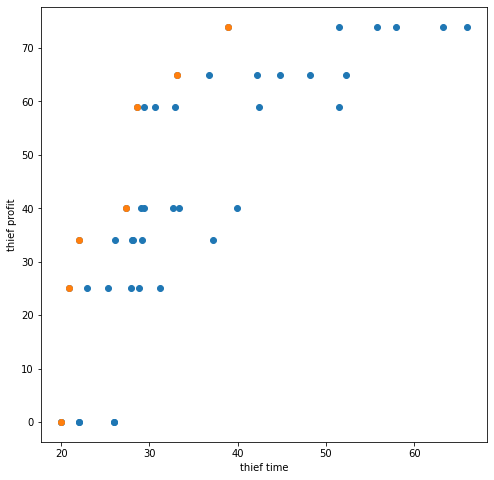

In [ ]:
def plot_solutions(all_solutions):
    plt.figure(figsize=(8,8))
    plt.scatter([s.total_time() for s in all_solutions if s.valid], 
                [s.total_profit() for s in all_solutions if s.valid])
    plt.scatter([s.total_time() for s in nd_solutions.solutions], 
                [s.total_profit() for s in nd_solutions.solutions])
    plt.xlabel('thief time')
    plt.ylabel('thief profit')
    plt.show()
plot_solutions(all_solutions)

# Particle Swarm

In [ ]:
import numpy as np

# uses discrete swap operations probabilistically per Goldbach et al to map
# continuous search space into a discrete search space for TSP/KSP
class TTPSwarm:
    '''
    Initialises a new particle swarm, containing x particles with number of
    dimensions d (TSP) and items n (KSP) defined by the supplied problem.
    w = inertia coefficient
    c1 = pbest acceleration coefficient
    c2 = gbest acceleration coefficient
    '''
    def __init__(self, problem, x, w=0.9, c1=0.2, c2=0.1):
        self.problem = problem
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.particles = [TTPParticle(self) for i in range(x)]
        self.gbest = self.particles[0] # as good as any other
        
    def update(self):
        '''
        Updates every particle in the entire swarm and calculates new gbest.
        '''
        # update each swarm member
        for p in self.particles:
            p.update()

        # calculate new gbest of the whole swarm
        for p in self.particles:
            if p.pbest[0] > self.gbest.pbest[0]:
                self.gbest = p

    def __repr__(self):
        return "TTPSwarm(problem=" + str(self.problem) + ",x=" + str(len(self.particles)) + ",gbest=" + str(self.gbest)

class TTPParticle:
    '''
    Initialises a TTP particle belonging to the swarm with a random location
    and velocity within the (d+n) dimensional search space.
    '''
    def __init__(self, swarm):
        self.swarm = swarm
        # problems where there is 10 times total weight, to knapsack capacity
        # should only pick an item at most 1/10th of the time - this simple
        # heuristic prevents too many unfeasible initial solutions
        items_to_pack = int(0.9 * self.swarm.problem.num_items * self.swarm.problem.packing_ratio)
        k = [k for k in self.swarm.problem.nodes.keys()]
        # random permutation of tour and random (following packing ratio) of items
        self.x = np.append(
            np.append(k[0], np.random.permutation(k[1:])),
            np.random.permutation(np.append([1] * items_to_pack, [0] * (self.swarm.problem.num_items - items_to_pack)))
        )
        self.v = np.append(
            np.random.rand(self.swarm.problem.dimension) - 0.5,
            np.random.rand(self.swarm.problem.num_items) - (1.0 - self.swarm.problem.packing_ratio)
        )
        self.pbest = (0, self.x.copy())
        self.solution = None

    def update(self):
        '''
        Update this particle using PSO update algorithm. Generates a solution.
        If solution is better than any found so far, updates pbest.
        '''
        # update particle velocity and location in search space
        r1 = np.random.rand(len(self.x))
        r2 = np.random.rand(len(self.x))
        self.v = self.swarm.w * self.v \
                    + self.swarm.c1 * r1 * (self.calc_discrete_velocity_operator(self.x, self.pbest[1])) \
                    + self.swarm.c2 * r2 * (self.calc_discrete_velocity_operator(self.x, self.swarm.gbest.pbest[1]))
        self.apply_discrete_velocity_operator(self.v)
        
        # generate the tour and packing plan from this particles position
        self.solution = self.to_solution()
        
        # if this is my new personal best mark it
        if self.solution.valid:
            score = self.solution.total_profit() / self.solution.total_time()
            if score > self.pbest[0]:
                self.pbest = (score, self.x.copy())

    def calc_discrete_velocity_operator(self, x1, x2):
        '''
        Calculate a 'velocity' between two discrete states; the difference
        between the two discrete states will always be an integer array of
        -1, 0 or 1 indicating the direction in which the state should be pushed
        via swap operations such that state x1 moves closer to state x2.
        '''
        v = np.zeros(len(x1))
        for i, x in enumerate(x1[:self.swarm.problem.dimension]):
            i2 = np.where(x2[:self.swarm.problem.dimension] == x)
            v[i] = 1 if i2[0][0] > i else -1 if i2[0][0] < i else 0
        for i, p in enumerate(x1[self.swarm.problem.dimension:]):
            p2 = x2[self.swarm.problem.dimension + i]
            v[self.swarm.problem.dimension + i] = p2 - p
        return v

    def apply_discrete_velocity_operator(self, v):
        '''
        Apply a 'velocity' between two discrete states; v is no longer applied
        continuously per time step to x but a higher velocity in a dimension
        indicates a higher probability per time step that the state x will apply
        a swap operator between states in the direction of the velocity.
        '''
        r = np.random.rand(len(self.x))
        tour_swaps = 0
        packing_swaps = 0
        for i, v in enumerate(self.v[:self.swarm.problem.dimension]):
            if v > 0 and r[i] < v and i < self.swarm.problem.dimension - 1:
                self.x[i], self.x[i+1] = self.x[i+1], self.x[i]
                tour_swaps += 1
            elif v < 0 and r[i] < -v and i > 1:
                self.x[i], self.x[i-1] = self.x[i-1], self.x[i]
                tour_swaps += 1
        for i, v in enumerate(self.v[self.swarm.problem.dimension:]):
            if v > 0 and r[i] < v:
                #print(f"adding an item because v = {v} and r[{i}] = {r[i]}")
                self.x[self.swarm.problem.dimension + i] = 1
                packing_swaps += 1
            elif v < 0 and r[i] < -v and i > 0:
                #print(f"removing an item because v = {v} and r[{i}] = {r[i]}")
                self.x[self.swarm.problem.dimension + i] = 0
                packing_swaps += 1
        #print(f'tour swaps {tour_swaps} packing swaps {packing_swaps}')
   
    def to_solution(self):
        '''
        Return the solution for the tour and packing plan for this particle state
        '''
        tour = self.x[:self.swarm.problem.dimension]
        plan = [True if i > 0.5 else False for i in self.x[self.swarm.problem.dimension:]]
        pack = self.swarm.problem.from_packing_plan(plan)
        return TTPSolution(self.swarm.problem, tour, pack)

    def __repr__(self):
        return "TTPParticle(x=" + str(self.x) + ",v=" + str(self.v)

In [ ]:
def run_particle_swarm(problem):
    # adjust epochs to problem complexity to maintain average run time
    epochs = int(10000 // problem.dimension)
    generations_per_epoch = 8
    reset_chance = 0.2
    c1 = 0.1
    c2 = 0.05
    particles = 50
    weight = 1.0

    # generate the swarm
    swarm = TTPSwarm(problem, particles, weight, c1, c2)
    all_solutions = []
    for epoch in range(epochs):
        print(f'epoch {epoch}')
        # apply pso updates
        for generation in range(generations_per_epoch):
            swarm.update()
        for p in swarm.particles:
            # store this particles best solution per epoch
            if p.pbest[0] > 0:
                s = swarm.to_solution(p.pbest[1])
                all_solutions.append(s)
            # completely rerandomise the velocity and reset best solution sometimes
            if random.random() < reset_chance:
                p.v = np.append(
                    np.random.rand(swarm.problem.dimension) - 0.5,
                    np.random.rand(swarm.problem.num_items) - (1.0 - swarm.problem.packing_ratio)
                )
                p.pbest = (0, p.x.copy())
        # each epoch allow gbest to dominate more
        swarm.w *= math.pow(0.5, 1.0 / epochs)
        swarm.c1 *= math.pow(0.1, 1.0 / epochs)
        swarm.c2 *= math.pow(0.25, 1.0 / epochs)
    
    # return the solutions found
    return all_solutions

In [ ]:
# draw chart for this combo
problem = problems['a280-n279.txt']
all_solutions = run_particle_swarm(problem)
nd_solutions = TTPNonDominatedSolutions(1000)
nd_solutions.add_new_solutions(all_solutions)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34


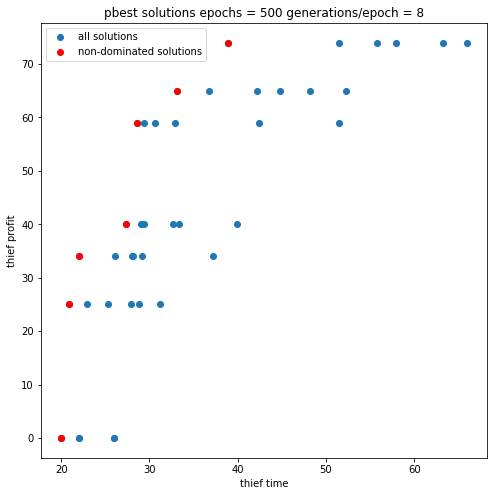

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter([s.total_time() for s in all_solutions if s.valid], 
          [s.total_profit() for s in all_solutions if s.valid],
          #c=[matplotlib.colors.to_rgba((0.1, 0.1, 1.0), s.alpha * 0.2) for s in all_solutions if s.valid],
          label='all solutions')
plt.scatter([s.total_time() for s in nd_solutions.solutions], 
          [s.total_profit() for s in nd_solutions.solutions],
          c='red', label='non-dominated solutions')
plt.title(f"pbest solutions epochs = {epochs} generations/epoch = {generations_per_epoch}")
plt.xlabel('thief time')
plt.ylabel('thief profit')
plt.legend()
plt.show()

# Results Submission

In [ ]:
def generate_competition_output(problem, all_solutions):
    assert problem, "requires a problem"
    assert all_solutions, "requires solutions"

    # our name!
    team_name = 'ECMM409-Team-Zeta'

    # max number of solutions allowed for each test as defined in the competition rules
    max_solutions = {
        "a280-n279": 100,
        "a280-n1395": 100,
        "a280-n2790": 100,
        "fnl4461-n4460": 50,
        "fnl4461-n22300": 50,
        "fnl4461-n44600": 50,
        "pla33810-n33809": 20,
        "pla33810-n169045": 20,
        "pla33810-n338090": 20,
        "test-example-n4": 8
    }

    # generate a set of non-dominated solution up to this maximum
    nd_solutions = TTPNonDominatedSolutions(max_solutions[problem.filename])
    nd_solutions.add_new_solutions(all_solutions)

    # generate the output the competition expects in the correct format
    with open(team_name + "_" + problem.filename + ".z", "wt") as fo:
        for s in nd_solutions.solutions:
            tour = ' '.join([str(n) for n in s.nodes])
            fo.write(tour + '\n')
            packing = ' '.join(["1" if i in s.items else "0" for i in problem.items.keys()])
            fo.write(packing + '\n\n')
    with open(team_name + "_" + problem.filename + ".f", "wt") as fo:
        for s in nd_solutions.solutions:
            fo.write(str(s.total_time()) + ' ' + str(s.total_profit()) + '\n')

# Results Generation

In [ ]:
# invoke a specific algorithm for a specific problem and return a list of solutions
def problem_runner(problem_algorithm):
    problem_string, algorithm = problem_algorithm[0], problem_algorithm[1]
    problem = problems[problem_string]
    if algorithm == 'PSO':
        solutions = run_particle_swarm(problem)
    elif algorithm == 'ACO':
        # TODO Wamika - call ACO
        solutions = []
    elif algorithm == 'MOEA':
        # TODO Zeng - tune based on problem.dimensions? 15 minutes runtime is good
        s = TTPSolutionEA(problem)
        s.run(100, 100)
    else:
        assert False, 'unknown algorithm'
    # stamp the solution with the algorithm that found it
    for s in solutions:
        s.algorithm = algorithm
    return solutions

In [ ]:
# generate a matrix of problems x algorithms and run in parallel
cpus = multiprocessing.cpu_count()
algorithms = ['PSO', 'ACO', 'MOEA']
problem_algorithms = [(p,a) for p in problems for a in algorithms]
problem_solutions = {p:[] for p in problems}
print(f'using {cpus} cpus')
with multiprocessing.Pool(processes=cpus) as pool:
    all_solutions = pool.map(problem_runner, problem_algorithms)
for s, pa in zip(all_solutions, problem_algorithms):
    problem_solutions[pa[0]].extend(s)
for p,s in problem_solutions.items():
    generate_competition_output(problems[p], s)

using 2 cpus


In [ ]:
!ls *.f

ECMM409-Team-Zeta_a280-n1395.f	    ECMM409-Team-Zeta_fnl4461-n4460.f
ECMM409-Team-Zeta_a280-n2790.f	    ECMM409-Team-Zeta_pla33810-n169045.f
ECMM409-Team-Zeta_a280-n279.f	    ECMM409-Team-Zeta_pla33810-n338090.f
ECMM409-Team-Zeta_fnl4461-n22300.f  ECMM409-Team-Zeta_pla33810-n33809.f
ECMM409-Team-Zeta_fnl4461-n44600.f  ECMM409-Team-Zeta_test-example-n4.f


In [ ]:
!ls *.z

ECMM409-Team-Zeta_a280-n1395.z	    ECMM409-Team-Zeta_fnl4461-n4460.z
ECMM409-Team-Zeta_a280-n2790.z	    ECMM409-Team-Zeta_pla33810-n169045.z
ECMM409-Team-Zeta_a280-n279.z	    ECMM409-Team-Zeta_pla33810-n338090.z
ECMM409-Team-Zeta_fnl4461-n22300.z  ECMM409-Team-Zeta_pla33810-n33809.z
ECMM409-Team-Zeta_fnl4461-n44600.z  ECMM409-Team-Zeta_test-example-n4.z
